# 1.2) Supervised Localization

An EfficientNet is trained here to perform a regression task which assigns a location, that is the x and y position, to each laser point in an image.

# Import statements
Following packages are necessary:

In [1]:
import random
import utils

import tensorflow as tf
import numpy as np
import segmentation_models as sm

from efficientnet.tfkeras import EfficientNetB0

from efficientnet.tfkeras import preprocess_input as pre_eff
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from lastengen import LASTENSequence
from matplotlib import pyplot as plt

Segmentation Models: using `tf.keras` framework.


# Checks

The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.2.0-rc3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data

Import training images

In [3]:
path_train = r'/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/train'
path_validation = r'/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
path_test = r'/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding

Seeds are set to ensure reproducible training.

In [4]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network

An EfficientNet network is instantiated with keras to run a regression task.

In [5]:
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(height, width, 1), dropout=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(2 * grid_width * grid_height, activation='linear',)(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 1) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 192, 192, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 192, 192, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 192, 192, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

# Data Preparation

The generator sequence for training is built.

In [6]:
image_ids = [3]

train_gen = LASTENSequence(path_train,
                           batch_size=1,
                           image_ids=image_ids,
                           preprocess_input=pre_eff,
                           shuffle=False,
                           augment=False,
                           width=width,
                           height=height,
                           label="keypoints")

#validation_gen = LASTENSequence(path_validation,
#                                batch_size=8,
#                                preprocess_input=pre_une,
#                                width=width,
#                                height=height)

#test_gen = LASTENSequence(path_train,
#                          batch_size=8,
#                          preprocess_input=pre_une,
#                          width=width,
#                          height=height)

# Training Preparation

Prepare the settings for training the model.

In [7]:
logger = CSVLogger("experiments/localization.log")
checker = ModelCheckpoint("experiments/localization/weights.{epoch:02d}.hdf5",
                          period=50)

callbacks = [logger, checker]

model.compile(optimizer='adam', loss='mse', metrics=['mape'])

# Training

The model is fitted with a generator.

In [8]:
model.fit_generator(train_gen,
                    epochs=3000,
                    callbacks=callbacks,
                    validation_data=train_gen,
                    validation_freq=1,
                    use_multiprocessing=False,
                    workers=10,
                    max_queue_size=32)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3000
1/1 [==============================] - 2s 2s/step - loss: 2.2876 - mape: 100.4505 - val_loss: 2.2044 - val_mape: 99.8884
Epoch 2/3000
1/1 [==============================] - 0s 343ms/step - loss: 1.6099 - mape: 83.3391 - val_loss: 2.1994 - val_mape: 99.7733
Epoch 3/3000
1/1 [==============================] - 0s 345ms/step - loss: 1.0375 - mape: 65.3042 - val_loss: 2.1933 - val_mape: 99.6311
Epoch 4/3000
1/1 [==============================] - 0s 344ms/step - loss: 0.5903 - mape: 47.0919 - val_loss: 2.1856 - val_mape: 99.4500
Epoch 5/3000
1/1 [==============================] - 0s 338ms/step - loss: 0.2839 - mape: 30.2536 - val_loss: 2.1758 - val_mape: 99.2197
Epoch 6/3000
1/1 [==============================] - 0s 339ms/step - loss: 0.1153 - mape: 18.0455 - val_loss: 2.1640 - val_mape: 98.9411
Epoch 7/3000
1/1 [==============================] - 0s 341ms/step - loss: 0.0601 - mape: 14.0360 - val_loss: 2

Epoch 59/3000
1/1 [==============================] - 0s 339ms/step - loss: 1.4508e-04 - mape: 0.7098 - val_loss: 2.1013 - val_mape: 97.4634
Epoch 60/3000
1/1 [==============================] - 0s 338ms/step - loss: 1.4695e-04 - mape: 0.7099 - val_loss: 2.1003 - val_mape: 97.4387
Epoch 61/3000
1/1 [==============================] - 0s 339ms/step - loss: 1.2887e-04 - mape: 0.6686 - val_loss: 2.0990 - val_mape: 97.4090
Epoch 62/3000
1/1 [==============================] - 0s 337ms/step - loss: 1.0166e-04 - mape: 0.5989 - val_loss: 2.0977 - val_mape: 97.3773
Epoch 63/3000
1/1 [==============================] - 0s 447ms/step - loss: 9.0465e-05 - mape: 0.5528 - val_loss: 2.0965 - val_mape: 97.3472
Epoch 64/3000
1/1 [==============================] - 0s 335ms/step - loss: 9.4570e-05 - mape: 0.5408 - val_loss: 2.0954 - val_mape: 97.3213
Epoch 65/3000
1/1 [==============================] - 0s 339ms/step - loss: 9.2371e-05 - mape: 0.5295 - val_loss: 2.0946 - val_mape: 97.3000
Epoch 66/3000
1/1 [=

1/1 [==============================] - 0s 341ms/step - loss: 1.0627e-09 - mape: 0.0018 - val_loss: 2.0146 - val_mape: 95.3402
Epoch 176/3000
1/1 [==============================] - 0s 337ms/step - loss: 8.4779e-10 - mape: 0.0016 - val_loss: 2.0141 - val_mape: 95.3284
Epoch 177/3000
1/1 [==============================] - 0s 335ms/step - loss: 8.6972e-10 - mape: 0.0016 - val_loss: 2.0136 - val_mape: 95.3166
Epoch 178/3000
1/1 [==============================] - 0s 338ms/step - loss: 7.8661e-10 - mape: 0.0016 - val_loss: 2.0131 - val_mape: 95.3048
Epoch 179/3000
1/1 [==============================] - 0s 341ms/step - loss: 5.7817e-10 - mape: 0.0014 - val_loss: 2.0127 - val_mape: 95.2932
Epoch 180/3000
1/1 [==============================] - 0s 334ms/step - loss: 5.3946e-10 - mape: 0.0013 - val_loss: 2.0122 - val_mape: 95.2816
Epoch 181/3000
1/1 [==============================] - 0s 335ms/step - loss: 5.6145e-10 - mape: 0.0013 - val_loss: 2.0117 - val_mape: 95.2701
Epoch 182/3000
1/1 [========

Epoch 232/3000
1/1 [==============================] - 0s 336ms/step - loss: 2.7175e-12 - mape: 9.1056e-05 - val_loss: 1.9921 - val_mape: 94.7849
Epoch 233/3000
1/1 [==============================] - 0s 336ms/step - loss: 2.1681e-12 - mape: 8.1226e-05 - val_loss: 1.9918 - val_mape: 94.7771
Epoch 234/3000
1/1 [==============================] - 0s 337ms/step - loss: 1.7109e-12 - mape: 7.2628e-05 - val_loss: 1.9915 - val_mape: 94.7693
Epoch 235/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.8587e-12 - mape: 7.5249e-05 - val_loss: 1.9911 - val_mape: 94.7616
Epoch 236/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.8151e-12 - mape: 7.5307e-05 - val_loss: 1.9908 - val_mape: 94.7539
Epoch 237/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.4860e-12 - mape: 6.7857e-05 - val_loss: 1.9905 - val_mape: 94.7463
Epoch 238/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.4491e-12 - mape: 6.6509e-05 - val_loss: 1.9902 - val

1/1 [==============================] - 0s 340ms/step - loss: 5.9322e-15 - mape: 3.1518e-06 - val_loss: 1.9672 - val_mape: 94.1689
Epoch 345/3000
1/1 [==============================] - 0s 336ms/step - loss: 5.6525e-15 - mape: 2.8992e-06 - val_loss: 1.9670 - val_mape: 94.1654
Epoch 346/3000
1/1 [==============================] - 0s 342ms/step - loss: 5.0549e-15 - mape: 2.7765e-06 - val_loss: 1.9669 - val_mape: 94.1619
Epoch 347/3000
1/1 [==============================] - 0s 339ms/step - loss: 5.8061e-15 - mape: 3.0518e-06 - val_loss: 1.9668 - val_mape: 94.1584
Epoch 348/3000
1/1 [==============================] - 0s 342ms/step - loss: 5.9267e-15 - mape: 3.0609e-06 - val_loss: 1.9666 - val_mape: 94.1550
Epoch 349/3000
1/1 [==============================] - 0s 336ms/step - loss: 4.9837e-15 - mape: 2.7178e-06 - val_loss: 1.9665 - val_mape: 94.1516
Epoch 350/3000
1/1 [==============================] - 1s 1s/step - loss: 5.7841e-15 - mape: 3.1084e-06 - val_loss: 1.9663 - val_mape: 94.1483
Epo

1/1 [==============================] - 0s 336ms/step - loss: 5.7293e-15 - mape: 2.9113e-06 - val_loss: 1.9592 - val_mape: 93.9728
Epoch 457/3000
1/1 [==============================] - 0s 336ms/step - loss: 5.7457e-15 - mape: 2.8912e-06 - val_loss: 1.9592 - val_mape: 93.9721
Epoch 458/3000
1/1 [==============================] - 0s 342ms/step - loss: 5.4661e-15 - mape: 2.8297e-06 - val_loss: 1.9592 - val_mape: 93.9713
Epoch 459/3000
1/1 [==============================] - 0s 338ms/step - loss: 5.1865e-15 - mape: 2.8799e-06 - val_loss: 1.9591 - val_mape: 93.9705
Epoch 460/3000
1/1 [==============================] - 0s 335ms/step - loss: 5.4990e-15 - mape: 2.8798e-06 - val_loss: 1.9591 - val_mape: 93.9696
Epoch 461/3000
1/1 [==============================] - 0s 340ms/step - loss: 5.6964e-15 - mape: 2.9671e-06 - val_loss: 1.9590 - val_mape: 93.9686
Epoch 462/3000
1/1 [==============================] - 0s 334ms/step - loss: 5.1591e-15 - mape: 2.7671e-06 - val_loss: 1.9590 - val_mape: 93.9677


1/1 [==============================] - 0s 335ms/step - loss: 5.7129e-15 - mape: 2.9926e-06 - val_loss: 1.7687 - val_mape: 89.3163
Epoch 569/3000
1/1 [==============================] - 0s 337ms/step - loss: 5.0769e-15 - mape: 2.7234e-06 - val_loss: 1.7604 - val_mape: 89.1060
Epoch 570/3000
1/1 [==============================] - 0s 336ms/step - loss: 5.4223e-15 - mape: 2.9012e-06 - val_loss: 1.7517 - val_mape: 88.8885
Epoch 571/3000
1/1 [==============================] - 0s 334ms/step - loss: 5.7896e-15 - mape: 3.0255e-06 - val_loss: 1.7428 - val_mape: 88.6635
Epoch 572/3000
1/1 [==============================] - 0s 335ms/step - loss: 5.2578e-15 - mape: 2.7887e-06 - val_loss: 1.7337 - val_mape: 88.4310
Epoch 573/3000
1/1 [==============================] - 0s 336ms/step - loss: 5.4003e-15 - mape: 2.9795e-06 - val_loss: 1.7243 - val_mape: 88.1911
Epoch 574/3000
1/1 [==============================] - 0s 340ms/step - loss: 5.8609e-15 - mape: 3.0819e-06 - val_loss: 1.7146 - val_mape: 87.9435


1/1 [==============================] - 0s 335ms/step - loss: 6.1460e-15 - mape: 3.2147e-06 - val_loss: 0.3748 - val_mape: 41.1390
Epoch 681/3000
1/1 [==============================] - 0s 336ms/step - loss: 6.0089e-15 - mape: 3.0804e-06 - val_loss: 0.3677 - val_mape: 40.7495
Epoch 682/3000
1/1 [==============================] - 0s 337ms/step - loss: 6.3433e-15 - mape: 3.1739e-06 - val_loss: 0.3608 - val_mape: 40.3635
Epoch 683/3000
1/1 [==============================] - 0s 336ms/step - loss: 6.0089e-15 - mape: 3.2241e-06 - val_loss: 0.3540 - val_mape: 39.9809
Epoch 684/3000
1/1 [==============================] - 0s 339ms/step - loss: 5.6909e-15 - mape: 2.9279e-06 - val_loss: 0.3473 - val_mape: 39.6016
Epoch 685/3000
1/1 [==============================] - 0s 338ms/step - loss: 5.8006e-15 - mape: 3.0347e-06 - val_loss: 0.3407 - val_mape: 39.2258
Epoch 686/3000
1/1 [==============================] - 0s 336ms/step - loss: 5.8335e-15 - mape: 2.9645e-06 - val_loss: 0.3343 - val_mape: 38.8534


1/1 [==============================] - 0s 336ms/step - loss: 6.1679e-15 - mape: 3.1424e-06 - val_loss: 0.0531 - val_mape: 15.4788
Epoch 793/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.4475e-15 - mape: 3.2413e-06 - val_loss: 0.0523 - val_mape: 15.3701
Epoch 794/3000
1/1 [==============================] - 0s 336ms/step - loss: 5.7951e-15 - mape: 3.0222e-06 - val_loss: 0.0516 - val_mape: 15.2628
Epoch 795/3000
1/1 [==============================] - 0s 336ms/step - loss: 5.8499e-15 - mape: 2.9686e-06 - val_loss: 0.0509 - val_mape: 15.1568
Epoch 796/3000
1/1 [==============================] - 0s 337ms/step - loss: 5.7457e-15 - mape: 3.0288e-06 - val_loss: 0.0502 - val_mape: 15.0522
Epoch 797/3000
1/1 [==============================] - 0s 336ms/step - loss: 6.1734e-15 - mape: 2.9338e-06 - val_loss: 0.0495 - val_mape: 14.9488
Epoch 798/3000
1/1 [==============================] - 0s 335ms/step - loss: 5.8444e-15 - mape: 3.0635e-06 - val_loss: 0.0488 - val_mape: 14.8468


Epoch 905/3000
1/1 [==============================] - 0s 339ms/step - loss: 6.1953e-15 - mape: 3.1005e-06 - val_loss: 0.0175 - val_mape: 8.9030
Epoch 906/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.0144e-15 - mape: 3.0661e-06 - val_loss: 0.0174 - val_mape: 8.8765
Epoch 907/3000
1/1 [==============================] - 0s 336ms/step - loss: 6.2227e-15 - mape: 3.1157e-06 - val_loss: 0.0173 - val_mape: 8.8504
Epoch 908/3000
1/1 [==============================] - 0s 342ms/step - loss: 5.4826e-15 - mape: 2.9577e-06 - val_loss: 0.0172 - val_mape: 8.8246
Epoch 909/3000
1/1 [==============================] - 0s 336ms/step - loss: 5.7238e-15 - mape: 2.9912e-06 - val_loss: 0.0171 - val_mape: 8.7991
Epoch 910/3000
1/1 [==============================] - 0s 338ms/step - loss: 6.4914e-15 - mape: 3.2707e-06 - val_loss: 0.0170 - val_mape: 8.7739
Epoch 911/3000
1/1 [==============================] - 0s 337ms/step - loss: 6.1844e-15 - mape: 3.0424e-06 - val_loss: 0.0169 - val_mape:

Epoch 962/3000
1/1 [==============================] - 0s 338ms/step - loss: 5.8335e-15 - mape: 2.9449e-06 - val_loss: 0.0135 - val_mape: 7.7999
Epoch 963/3000
1/1 [==============================] - 0s 336ms/step - loss: 6.1679e-15 - mape: 3.1099e-06 - val_loss: 0.0134 - val_mape: 7.7864
Epoch 964/3000
1/1 [==============================] - 0s 334ms/step - loss: 6.6723e-15 - mape: 3.2184e-06 - val_loss: 0.0134 - val_mape: 7.7729
Epoch 965/3000
1/1 [==============================] - 0s 338ms/step - loss: 6.5352e-15 - mape: 3.3532e-06 - val_loss: 0.0133 - val_mape: 7.7597
Epoch 966/3000
1/1 [==============================] - 0s 339ms/step - loss: 5.8773e-15 - mape: 2.9251e-06 - val_loss: 0.0133 - val_mape: 7.7466
Epoch 967/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.1460e-15 - mape: 3.0369e-06 - val_loss: 0.0132 - val_mape: 7.7336
Epoch 968/3000
1/1 [==============================] - 0s 335ms/step - loss: 5.8938e-15 - mape: 3.0543e-06 - val_loss: 0.0132 - val_mape:

Epoch 1019/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.0692e-15 - mape: 3.2110e-06 - val_loss: 0.0116 - val_mape: 7.2255
Epoch 1020/3000
1/1 [==============================] - 0s 340ms/step - loss: 6.0254e-15 - mape: 3.0346e-06 - val_loss: 0.0115 - val_mape: 7.2183
Epoch 1021/3000
1/1 [==============================] - 0s 339ms/step - loss: 5.9267e-15 - mape: 2.9474e-06 - val_loss: 0.0115 - val_mape: 7.2112
Epoch 1022/3000
1/1 [==============================] - 0s 344ms/step - loss: 6.1898e-15 - mape: 3.1590e-06 - val_loss: 0.0115 - val_mape: 7.2042
Epoch 1023/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.0911e-15 - mape: 3.1210e-06 - val_loss: 0.0115 - val_mape: 7.1972
Epoch 1024/3000
1/1 [==============================] - 0s 335ms/step - loss: 5.9047e-15 - mape: 3.1164e-06 - val_loss: 0.0114 - val_mape: 7.1903
Epoch 1025/3000
1/1 [==============================] - 0s 337ms/step - loss: 6.0747e-15 - mape: 3.1006e-06 - val_loss: 0.0114 - va

1/1 [==============================] - 0s 335ms/step - loss: 6.6997e-15 - mape: 3.3527e-06 - val_loss: 0.0101 - val_mape: 6.7534
Epoch 1132/3000
1/1 [==============================] - 0s 334ms/step - loss: 7.2535e-15 - mape: 3.5526e-06 - val_loss: 0.0101 - val_mape: 6.7513
Epoch 1133/3000
1/1 [==============================] - 0s 336ms/step - loss: 6.1295e-15 - mape: 3.1604e-06 - val_loss: 0.0101 - val_mape: 6.7491
Epoch 1134/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.8752e-15 - mape: 3.3375e-06 - val_loss: 0.0101 - val_mape: 6.7469
Epoch 1135/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.7929e-15 - mape: 3.3286e-06 - val_loss: 0.0101 - val_mape: 6.7448
Epoch 1136/3000
1/1 [==============================] - 0s 339ms/step - loss: 6.1240e-15 - mape: 3.1705e-06 - val_loss: 0.0101 - val_mape: 6.7427
Epoch 1137/3000
1/1 [==============================] - 0s 337ms/step - loss: 6.0911e-15 - mape: 3.0855e-06 - val_loss: 0.0101 - val_mape: 6.7406
E

1/1 [==============================] - 0s 336ms/step - loss: 6.2392e-15 - mape: 3.1771e-06 - val_loss: 0.0097 - val_mape: 6.6069
Epoch 1244/3000
1/1 [==============================] - 0s 334ms/step - loss: 6.3159e-15 - mape: 3.0909e-06 - val_loss: 0.0097 - val_mape: 6.6062
Epoch 1245/3000
1/1 [==============================] - 0s 340ms/step - loss: 6.8368e-15 - mape: 3.3657e-06 - val_loss: 0.0097 - val_mape: 6.6055
Epoch 1246/3000
1/1 [==============================] - 0s 337ms/step - loss: 6.3982e-15 - mape: 3.1644e-06 - val_loss: 0.0097 - val_mape: 6.6048
Epoch 1247/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.3379e-15 - mape: 3.2502e-06 - val_loss: 0.0097 - val_mape: 6.6041
Epoch 1248/3000
1/1 [==============================] - 0s 338ms/step - loss: 6.4311e-15 - mape: 3.3203e-06 - val_loss: 0.0097 - val_mape: 6.6035
Epoch 1249/3000
1/1 [==============================] - 0s 337ms/step - loss: 6.3105e-15 - mape: 3.2802e-06 - val_loss: 0.0097 - val_mape: 6.6028
E

1/1 [==============================] - 0s 354ms/step - loss: 6.1679e-15 - mape: 3.1769e-06 - val_loss: 0.0095 - val_mape: 6.5608
Epoch 1356/3000
1/1 [==============================] - 0s 338ms/step - loss: 7.8017e-15 - mape: 3.8235e-06 - val_loss: 0.0095 - val_mape: 6.5606
Epoch 1357/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.6339e-15 - mape: 3.3632e-06 - val_loss: 0.0095 - val_mape: 6.5603
Epoch 1358/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.3050e-15 - mape: 3.2805e-06 - val_loss: 0.0095 - val_mape: 6.5601
Epoch 1359/3000
1/1 [==============================] - 0s 340ms/step - loss: 6.7162e-15 - mape: 3.1711e-06 - val_loss: 0.0095 - val_mape: 6.5599
Epoch 1360/3000
1/1 [==============================] - 0s 337ms/step - loss: 6.2666e-15 - mape: 3.2365e-06 - val_loss: 0.0095 - val_mape: 6.5597
Epoch 1361/3000
1/1 [==============================] - 0s 339ms/step - loss: 7.4070e-15 - mape: 3.6929e-06 - val_loss: 0.0095 - val_mape: 6.5595
E

1/1 [==============================] - 0s 337ms/step - loss: 6.6613e-15 - mape: 3.3922e-06 - val_loss: 0.0095 - val_mape: 6.5468
Epoch 1468/3000
1/1 [==============================] - 0s 336ms/step - loss: 7.2754e-15 - mape: 3.5873e-06 - val_loss: 0.0095 - val_mape: 6.5467
Epoch 1469/3000
1/1 [==============================] - 0s 336ms/step - loss: 6.7655e-15 - mape: 3.4377e-06 - val_loss: 0.0095 - val_mape: 6.5467
Epoch 1470/3000
1/1 [==============================] - 0s 335ms/step - loss: 6.6230e-15 - mape: 3.3953e-06 - val_loss: 0.0095 - val_mape: 6.5466
Epoch 1471/3000
1/1 [==============================] - 0s 336ms/step - loss: 8.0813e-15 - mape: 3.8976e-06 - val_loss: 0.0095 - val_mape: 6.5466
Epoch 1472/3000
1/1 [==============================] - 0s 336ms/step - loss: 7.3576e-15 - mape: 3.6318e-06 - val_loss: 0.0095 - val_mape: 6.5465
Epoch 1473/3000
1/1 [==============================] - 0s 339ms/step - loss: 7.2754e-15 - mape: 3.6215e-06 - val_loss: 0.0095 - val_mape: 6.5464
E

1/1 [==============================] - 0s 341ms/step - loss: 7.8346e-15 - mape: 3.7288e-06 - val_loss: 0.0095 - val_mape: 6.5425
Epoch 1580/3000
1/1 [==============================] - 0s 335ms/step - loss: 7.6208e-15 - mape: 3.7762e-06 - val_loss: 0.0095 - val_mape: 6.5425
Epoch 1581/3000
1/1 [==============================] - 0s 336ms/step - loss: 7.3028e-15 - mape: 3.5684e-06 - val_loss: 0.0095 - val_mape: 6.5425
Epoch 1582/3000
1/1 [==============================] - 0s 339ms/step - loss: 8.0101e-15 - mape: 3.7412e-06 - val_loss: 0.0095 - val_mape: 6.5425
Epoch 1583/3000
1/1 [==============================] - 0s 338ms/step - loss: 7.7414e-15 - mape: 3.8216e-06 - val_loss: 0.0095 - val_mape: 6.5425
Epoch 1584/3000
1/1 [==============================] - 0s 341ms/step - loss: 8.1362e-15 - mape: 3.9427e-06 - val_loss: 0.0095 - val_mape: 6.5424
Epoch 1585/3000
1/1 [==============================] - 0s 337ms/step - loss: 7.9607e-15 - mape: 3.7675e-06 - val_loss: 0.0095 - val_mape: 6.5424
E

1/1 [==============================] - 0s 336ms/step - loss: 1.0044e-14 - mape: 4.6764e-06 - val_loss: 0.0095 - val_mape: 6.5412
Epoch 1692/3000
1/1 [==============================] - 0s 337ms/step - loss: 8.5693e-15 - mape: 4.0455e-06 - val_loss: 0.0095 - val_mape: 6.5412
Epoch 1693/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.0230e-14 - mape: 4.6323e-06 - val_loss: 0.0095 - val_mape: 6.5412
Epoch 1694/3000
1/1 [==============================] - 0s 336ms/step - loss: 8.3664e-15 - mape: 3.9002e-06 - val_loss: 0.0095 - val_mape: 6.5412
Epoch 1695/3000
1/1 [==============================] - 0s 336ms/step - loss: 9.3149e-15 - mape: 4.3436e-06 - val_loss: 0.0095 - val_mape: 6.5412
Epoch 1696/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.0362e-14 - mape: 4.5197e-06 - val_loss: 0.0095 - val_mape: 6.5412
Epoch 1697/3000
1/1 [==============================] - 0s 335ms/step - loss: 9.3368e-15 - mape: 4.3471e-06 - val_loss: 0.0095 - val_mape: 6.5412
E

1/1 [==============================] - 0s 341ms/step - loss: 1.1574e-14 - mape: 4.9499e-06 - val_loss: 0.0095 - val_mape: 6.5409
Epoch 1804/3000
1/1 [==============================] - 0s 340ms/step - loss: 8.3226e-15 - mape: 3.8430e-06 - val_loss: 0.0095 - val_mape: 6.5409
Epoch 1805/3000
1/1 [==============================] - 0s 338ms/step - loss: 9.7700e-15 - mape: 4.4651e-06 - val_loss: 0.0095 - val_mape: 6.5409
Epoch 1806/3000
1/1 [==============================] - 0s 340ms/step - loss: 1.0938e-14 - mape: 4.7936e-06 - val_loss: 0.0095 - val_mape: 6.5409
Epoch 1807/3000
1/1 [==============================] - 0s 340ms/step - loss: 1.0039e-14 - mape: 4.5209e-06 - val_loss: 0.0095 - val_mape: 6.5409
Epoch 1808/3000
1/1 [==============================] - 0s 336ms/step - loss: 9.1669e-15 - mape: 4.3662e-06 - val_loss: 0.0095 - val_mape: 6.5409
Epoch 1809/3000
1/1 [==============================] - 0s 337ms/step - loss: 7.6318e-15 - mape: 3.8416e-06 - val_loss: 0.0095 - val_mape: 6.5409
E

1/1 [==============================] - 0s 343ms/step - loss: 9.0792e-15 - mape: 4.1141e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 1916/3000
1/1 [==============================] - 0s 336ms/step - loss: 9.0901e-15 - mape: 4.0533e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 1917/3000
1/1 [==============================] - 0s 337ms/step - loss: 8.2951e-15 - mape: 3.8008e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 1918/3000
1/1 [==============================] - 0s 337ms/step - loss: 8.4761e-15 - mape: 4.1342e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 1919/3000
1/1 [==============================] - 0s 335ms/step - loss: 7.8730e-15 - mape: 3.8240e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 1920/3000
1/1 [==============================] - 0s 340ms/step - loss: 8.8105e-15 - mape: 4.0251e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 1921/3000
1/1 [==============================] - 0s 338ms/step - loss: 9.5945e-15 - mape: 4.0895e-06 - val_loss: 0.0095 - val_mape: 6.5408
E

1/1 [==============================] - 0s 337ms/step - loss: 1.0510e-14 - mape: 4.5601e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2028/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.5993e-14 - mape: 6.1499e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2029/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.0642e-14 - mape: 4.7614e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2030/3000
1/1 [==============================] - 0s 340ms/step - loss: 1.2769e-14 - mape: 5.3386e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2031/3000
1/1 [==============================] - 0s 336ms/step - loss: 9.7700e-15 - mape: 4.4725e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2032/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.1875e-14 - mape: 5.1106e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2033/3000
1/1 [==============================] - 0s 339ms/step - loss: 9.8796e-15 - mape: 4.3458e-06 - val_loss: 0.0095 - val_mape: 6.5408
E

1/1 [==============================] - 0s 343ms/step - loss: 1.0883e-14 - mape: 4.8160e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2140/3000
1/1 [==============================] - 0s 335ms/step - loss: 9.1066e-15 - mape: 4.3036e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2141/3000
1/1 [==============================] - 0s 337ms/step - loss: 9.4081e-15 - mape: 4.3848e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2142/3000
1/1 [==============================] - 0s 339ms/step - loss: 9.0572e-15 - mape: 4.1659e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2143/3000
1/1 [==============================] - 0s 338ms/step - loss: 9.8138e-15 - mape: 4.5505e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2144/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.0916e-14 - mape: 4.8165e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2145/3000
1/1 [==============================] - 0s 340ms/step - loss: 8.7447e-15 - mape: 4.2990e-06 - val_loss: 0.0095 - val_mape: 6.5408
E

1/1 [==============================] - 0s 340ms/step - loss: 9.5342e-15 - mape: 4.3536e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2252/3000
1/1 [==============================] - 0s 339ms/step - loss: 9.3533e-15 - mape: 4.3586e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2253/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.0252e-14 - mape: 4.4864e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2254/3000
1/1 [==============================] - 0s 336ms/step - loss: 9.3259e-15 - mape: 4.3038e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2255/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.0477e-14 - mape: 4.6050e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2256/3000
1/1 [==============================] - 0s 336ms/step - loss: 9.4958e-15 - mape: 4.2777e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2257/3000
1/1 [==============================] - 0s 335ms/step - loss: 9.2820e-15 - mape: 4.1777e-06 - val_loss: 0.0095 - val_mape: 6.5408
E

1/1 [==============================] - 0s 338ms/step - loss: 1.1947e-14 - mape: 5.0044e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2364/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.3399e-14 - mape: 5.4810e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2365/3000
1/1 [==============================] - 0s 338ms/step - loss: 1.0823e-14 - mape: 4.6610e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2366/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.7988e-14 - mape: 6.8225e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2367/3000
1/1 [==============================] - 0s 338ms/step - loss: 1.5318e-14 - mape: 6.2266e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2368/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.2615e-14 - mape: 5.2285e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2369/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.3663e-14 - mape: 5.5626e-06 - val_loss: 0.0095 - val_mape: 6.5408
E

1/1 [==============================] - 0s 340ms/step - loss: 1.2084e-14 - mape: 5.1790e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2476/3000
1/1 [==============================] - 0s 337ms/step - loss: 1.2539e-14 - mape: 5.1304e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2477/3000
1/1 [==============================] - 0s 338ms/step - loss: 1.1870e-14 - mape: 4.7667e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2478/3000
1/1 [==============================] - 0s 339ms/step - loss: 1.1793e-14 - mape: 4.9998e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2479/3000
1/1 [==============================] - 0s 340ms/step - loss: 1.2599e-14 - mape: 5.1832e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2480/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.3092e-14 - mape: 5.3296e-06 - val_loss: 0.0095 - val_mape: 6.5408
Epoch 2481/3000
1/1 [==============================] - 0s 340ms/step - loss: 1.2276e-14 - mape: 5.0986e-06 - val_loss: 0.0095 - val_mape: 6.5408
E

1/1 [==============================] - 0s 338ms/step - loss: 3.6894e-07 - mape: 0.0366 - val_loss: 3.3430 - val_mape: 122.9771
Epoch 2590/3000
1/1 [==============================] - 0s 337ms/step - loss: 4.5420e-07 - mape: 0.0445 - val_loss: 3.2278 - val_mape: 120.8352
Epoch 2591/3000
1/1 [==============================] - 0s 335ms/step - loss: 9.6847e-08 - mape: 0.0175 - val_loss: 3.1163 - val_mape: 118.7239
Epoch 2592/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.7196e-07 - mape: 0.0221 - val_loss: 3.0107 - val_mape: 116.6929
Epoch 2593/3000
1/1 [==============================] - 0s 336ms/step - loss: 3.5578e-07 - mape: 0.0388 - val_loss: 2.9115 - val_mape: 114.7577
Epoch 2594/3000
1/1 [==============================] - 0s 339ms/step - loss: 1.3447e-07 - mape: 0.0235 - val_loss: 2.8173 - val_mape: 112.8902
Epoch 2595/3000
1/1 [==============================] - 0s 336ms/step - loss: 6.8975e-08 - mape: 0.0100 - val_loss: 2.7258 - val_mape: 111.0453
Epoch 2596/3000

Epoch 2647/3000
1/1 [==============================] - 0s 336ms/step - loss: 3.0150e-10 - mape: 4.6859e-04 - val_loss: 0.5508 - val_mape: 49.9183
Epoch 2648/3000
1/1 [==============================] - 0s 341ms/step - loss: 8.5255e-10 - mape: 0.0014 - val_loss: 0.5350 - val_mape: 49.2001
Epoch 2649/3000
1/1 [==============================] - 0s 339ms/step - loss: 7.3731e-10 - mape: 0.0017 - val_loss: 0.5197 - val_mape: 48.4913
Epoch 2650/3000
1/1 [==============================] - 1s 1s/step - loss: 2.1303e-10 - mape: 6.7120e-04 - val_loss: 0.5049 - val_mape: 47.7930
Epoch 2651/3000
1/1 [==============================] - 0s 339ms/step - loss: 5.1172e-10 - mape: 9.3914e-04 - val_loss: 0.4905 - val_mape: 47.1065
Epoch 2652/3000
1/1 [==============================] - 0s 337ms/step - loss: 6.1699e-10 - mape: 0.0015 - val_loss: 0.4765 - val_mape: 46.4319
Epoch 2653/3000
1/1 [==============================] - 0s 338ms/step - loss: 1.9138e-10 - mape: 8.3510e-04 - val_loss: 0.4630 - val_mape: 4

1/1 [==============================] - 0s 341ms/step - loss: 1.4507e-14 - mape: 5.6585e-06 - val_loss: 0.0177 - val_mape: 8.9592
Epoch 2760/3000
1/1 [==============================] - 0s 340ms/step - loss: 1.8241e-14 - mape: 5.6958e-06 - val_loss: 0.0171 - val_mape: 8.7940
Epoch 2761/3000
1/1 [==============================] - 0s 334ms/step - loss: 1.8284e-14 - mape: 5.6645e-06 - val_loss: 0.0164 - val_mape: 8.6306
Epoch 2762/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.2999e-14 - mape: 5.1355e-06 - val_loss: 0.0158 - val_mape: 8.4691
Epoch 2763/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.6519e-14 - mape: 5.4144e-06 - val_loss: 0.0152 - val_mape: 8.3094
Epoch 2764/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.7204e-14 - mape: 5.6238e-06 - val_loss: 0.0147 - val_mape: 8.1516
Epoch 2765/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.3646e-14 - mape: 5.3195e-06 - val_loss: 0.0141 - val_mape: 7.9956
E

1/1 [==============================] - 0s 337ms/step - loss: 1.2418e-14 - mape: 5.0203e-06 - val_loss: 5.8333e-04 - val_mape: 1.6129
Epoch 2871/3000
1/1 [==============================] - 0s 338ms/step - loss: 1.2637e-14 - mape: 5.0860e-06 - val_loss: 6.1892e-04 - val_mape: 1.6618
Epoch 2872/3000
1/1 [==============================] - 0s 335ms/step - loss: 1.1163e-14 - mape: 4.6558e-06 - val_loss: 6.5522e-04 - val_mape: 1.7103
Epoch 2873/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.1502e-14 - mape: 4.7643e-06 - val_loss: 6.9214e-04 - val_mape: 1.7583
Epoch 2874/3000
1/1 [==============================] - 0s 337ms/step - loss: 1.1738e-14 - mape: 4.8831e-06 - val_loss: 7.2968e-04 - val_mape: 1.8057
Epoch 2875/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.1744e-14 - mape: 4.8559e-06 - val_loss: 7.6781e-04 - val_mape: 1.8527
Epoch 2876/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.1782e-14 - mape: 4.7452e-06 - val_loss: 8.0

1/1 [==============================] - 0s 335ms/step - loss: 1.1354e-14 - mape: 4.7393e-06 - val_loss: 0.0053 - val_mape: 4.8689
Epoch 2983/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.1990e-14 - mape: 4.8531e-06 - val_loss: 0.0053 - val_mape: 4.8843
Epoch 2984/3000
1/1 [==============================] - 0s 337ms/step - loss: 1.2955e-14 - mape: 4.8593e-06 - val_loss: 0.0053 - val_mape: 4.8995
Epoch 2985/3000
1/1 [==============================] - 0s 338ms/step - loss: 1.1245e-14 - mape: 4.7734e-06 - val_loss: 0.0054 - val_mape: 4.9146
Epoch 2986/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.0735e-14 - mape: 4.5824e-06 - val_loss: 0.0054 - val_mape: 4.9295
Epoch 2987/3000
1/1 [==============================] - 0s 339ms/step - loss: 1.2506e-14 - mape: 4.8022e-06 - val_loss: 0.0054 - val_mape: 4.9443
Epoch 2988/3000
1/1 [==============================] - 0s 336ms/step - loss: 1.3175e-14 - mape: 5.4271e-06 - val_loss: 0.0055 - val_mape: 4.9589
E

In [9]:
X, y = train_gen[0]
y_pred = model.predict(X)

In [10]:
plt.rcParams['figure.figsize'] = (15, 15)

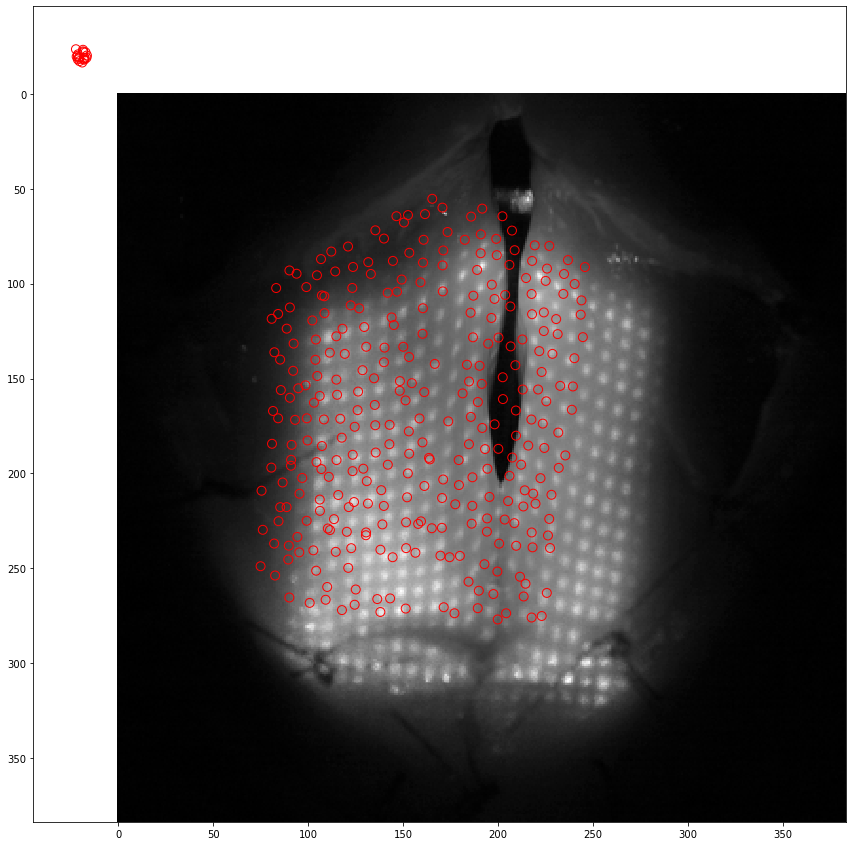

In [11]:
image = X[0]
keypoints = y_pred[0]

plt.clf()
plt.imshow(image[:,:,0], cmap="gray")

x_list = []
y_list = []

for index in range(0, 18*18):
    x_index = index * 2 
    
    x = (keypoints[x_index] - 1) * width
    y = (keypoints[x_index + 1] - 1) * height
    
    x_list.append(x)
    y_list.append(y)
    
    
plt.scatter(x_list, y_list,s=80,facecolors='none', edgecolors='r')